# Prototyping

> Proof of concept exploration of backprop optimization through MLP with number of nodes varying during training.

In [ ]:
# | default_exp prototyping

In [ ]:
# | export

import jax
import jax.numpy as jnp
import numpy as np
import optax
import equinox as eqx
from jax import random
from jax.random import PRNGKey, split

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.style as mplstyle

import seaborn as sns

In [ ]:
plt.style.use('default')
sns.set_theme(context='paper', style='white', palette='icefire', font='serif',
            font_scale=1, color_codes=True, rc={'text.usetex' : True})
mplstyle.use('fast')

In [ ]:
jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')

In [ ]:
# | export

class Model(eqx.Module):
    layers: list

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = jax.nn.relu(layer(x))
        return self.layers[-1](x)

In [ ]:
# | export

def MLP(layer_sizes, key):
    keys = split(key, len(layer_sizes) - 1)
    layers = [
        eqx.nn.Linear(in_size, out_size, key=k)
        for in_size, out_size, k in zip(layer_sizes[:-1], layer_sizes[1:], keys)
    ]
    return Model(layers)

In [ ]:
# | test


def test_mlp_initialization():
    key = random.PRNGKey(0)
    layer_sizes = [2, 3, 1]
    mlp = MLP(layer_sizes, key)
    assert len(mlp.layers) == 2
    assert mlp.layers[0].weight.shape == (3, 2)
    assert mlp.layers[0].bias.shape == (3,)
    assert mlp.layers[1].weight.shape == (1, 3)
    assert mlp.layers[1].bias.shape == (1,)


def test_mlp_forward_pass():
    key = random.PRNGKey(0)
    layer_sizes = [2, 3, 1]
    mlp = MLP(layer_sizes, key)
    x = jnp.array([[1.0, 2.0], [3.0, 4.0]])
    y = jax.vmap(mlp)(x)
    assert y.shape == (2, 1)

In [ ]:
# | test
test_mlp_initialization()

In [ ]:
# | test
test_mlp_forward_pass()

In [ ]:
# | export
# getters for pytree manipulation
def where_weight(linear):
    return linear.weight


def where_bias(linear):
    return linear.bias

In [ ]:
# | export


def add_node(mlp, key):
    new_layers = []

    # first layer
    initial_layer = mlp.layers[0]
    out_features, in_features = initial_layer.weight.shape
    new_inital_shape = (out_features + 1, in_features)
    new_initial_weight = jnp.resize(initial_layer.weight, new_inital_shape)
    new_initial_bias = jnp.resize(initial_layer.bias, (new_inital_shape[0],))
    new_initial_layer = eqx.nn.Linear(new_inital_shape[1], new_inital_shape[0], key=key)
    new_initial_layer = eqx.tree_at(where_weight, new_initial_layer, new_initial_weight)
    new_initial_layer = eqx.tree_at(where_bias, new_initial_layer, new_initial_bias)
    new_layers.append(new_initial_layer)

    # hidden layer(s)
    for i, layer in enumerate(mlp.layers[1:-1]):
        out_features, in_features = layer.weight.shape
        new_shape = (out_features + 1, in_features + 1)
        new_weight = jnp.resize(layer.weight, new_shape)
        new_bias = jnp.resize(layer.bias, (new_shape[0],))
        new_layer = eqx.nn.Linear(new_shape[1], new_shape[0], key=key)
        new_layer = eqx.tree_at(where_weight, new_layer, new_weight)
        new_layer = eqx.tree_at(where_bias, new_layer, new_bias)
        new_layers.append(new_layer)

    # final layer
    final_layer = mlp.layers[-1]
    out_features, in_features = final_layer.weight.shape
    new_final_shape = (out_features, in_features + 1)
    new_final_weight = jnp.resize(final_layer.weight, new_final_shape)
    new_final_bias = jnp.resize(final_layer.bias, (new_final_shape[0],))
    new_final_layer = eqx.nn.Linear(new_final_shape[1], new_final_shape[0], key=key)
    new_final_layer = eqx.tree_at(where_weight, new_final_layer, new_final_weight)
    new_final_layer = eqx.tree_at(where_bias, new_final_layer, new_final_bias)
    new_layers.append(new_final_layer)

    return Model(new_layers)

In [ ]:
# | test
def test_add_node():
    key = random.PRNGKey(0)
    layer_sizes = [2, 3, 1]
    mlp = MLP(layer_sizes, key)
    key, subkey = random.split(key)
    new_mlp = add_node(mlp, subkey)
    assert len(new_mlp.layers) == 2
    assert new_mlp.layers[0].weight.shape == (4, 2)
    assert new_mlp.layers[0].bias.shape == (4,)
    assert new_mlp.layers[1].weight.shape == (1, 4)
    assert new_mlp.layers[1].bias.shape == (1,)

In [ ]:
# | test
test_add_node()

In [ ]:
# | export
def remove_node(mlp, key):
    new_layers = []

    # first layer
    initial_layer = mlp.layers[0]
    out_features, in_features = initial_layer.weight.shape
    new_inital_shape = (out_features - 1, in_features)
    new_initial_weight = jnp.resize(initial_layer.weight, new_inital_shape)
    new_initial_bias = jnp.resize(initial_layer.bias, (new_inital_shape[0],))
    new_initial_layer = eqx.nn.Linear(new_inital_shape[1], new_inital_shape[0], key=key)
    new_initial_layer = eqx.tree_at(where_weight, new_initial_layer, new_initial_weight)
    new_initial_layer = eqx.tree_at(where_bias, new_initial_layer, new_initial_bias)
    new_layers.append(new_initial_layer)

    # hidden layer(s)
    for i, layer in enumerate(mlp.layers[1:-1]):
        out_features, in_features = layer.weight.shape
        new_shape = (out_features - 1, in_features - 1)
        new_weight = jnp.resize(layer.weight, new_shape)
        new_bias = jnp.resize(layer.bias, (new_shape[0],))
        new_layer = eqx.nn.Linear(new_shape[1], new_shape[0], key=key)
        new_layer = eqx.tree_at(where_weight, new_layer, new_weight)
        new_layer = eqx.tree_at(where_bias, new_layer, new_bias)
        new_layers.append(new_layer)

    # final layer
    final_layer = mlp.layers[-1]
    out_features, in_features = final_layer.weight.shape
    new_final_shape = (out_features, in_features - 1)
    new_final_weight = jnp.resize(final_layer.weight, new_final_shape)
    new_final_bias = jnp.resize(final_layer.bias, (new_final_shape[0],))
    new_final_layer = eqx.nn.Linear(new_final_shape[1], new_final_shape[0], key=key)
    new_final_layer = eqx.tree_at(where_weight, new_final_layer, new_final_weight)
    new_final_layer = eqx.tree_at(where_bias, new_final_layer, new_final_bias)
    new_layers.append(new_final_layer)

    return Model(new_layers)

In [ ]:
# | test
def test_remove_node():
    key = random.PRNGKey(0)
    layer_sizes = [2, 3, 1]
    mlp = MLP(layer_sizes, key)
    key, subkey = random.split(key)
    new_mlp = remove_node(mlp, subkey)
    assert len(new_mlp.layers) == 2
    assert new_mlp.layers[0].weight.shape == (2, 2)
    assert new_mlp.layers[0].bias.shape == (2,)
    assert new_mlp.layers[1].weight.shape == (1, 2)
    assert new_mlp.layers[1].bias.shape == (1,)

In [ ]:
# | test
test_remove_node()

In [ ]:
# | export

@eqx.filter_value_and_grad()
def compute_loss(params, x, y):
    preds = jax.vmap(params)(x)
    return jnp.mean((preds - y) ** 2)

In [ ]:
# | export

@eqx.filter_jit
def train_step(params, x, y, opt_state, opt_update):
    loss, grads = compute_loss(params, x, y)
    updates, opt_state = opt_update(grads, opt_state)
    params = eqx.apply_updates(params, updates)
    return loss, params, opt_state

In [ ]:
# Initialize training data
x = jnp.linspace(0, 2 * jnp.pi, 1000).reshape(-1, 1)
y = jnp.sin(jnp.linspace(0, 2 * jnp.pi, 1000)).reshape(-1, 1)

In [ ]:
# Initialize model and optimizer
key = PRNGKey(42)
layer_sizes = [1, 1024, 1]
model = MLP(layer_sizes, key)
opt = optax.adabelief(learning_rate=0.01)
opt_state = opt.init(model)

In [ ]:
def count_nodes(model):
    return model.layers[0].in_features + sum([layer.out_features for layer in model.layers]) # input nodes + hidden nodes + output nodes

In [ ]:
count_nodes(model)

1026

In [ ]:
# Training loop
num_epochs = 1000
add_node_every = 10
remove_node_every = 10
Loss_history = []
Node_history = []


In [ ]:
for epoch in range(num_epochs):
    loss, model, opt_state = train_step(model, x, y, opt_state, opt.update)
    key, addkey, subkey = split(key,3)
    n_nodes = count_nodes(model)
    Node_history.append(n_nodes)
    Loss_history.append(loss)
    if (epoch + 1) % add_node_every == 0 and random.uniform(addkey) < 0.05:
        
        model = add_node(model, addkey)
        print(f"Added node at epoch {epoch + 1}")
        opt_state = opt.init(model)
        print("Model reinitialized")

    if n_nodes >= 4 and (epoch + 1) % remove_node_every == 0 and random.uniform(subkey) < 0.05:

        model = remove_node(model, subkey)
        print(f"Removed node at epoch {epoch + 1}")
        opt_state = opt.init(model)
        print("Model reinitialized")

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss}")

Epoch 50, Loss: 0.5076100529162416
Epoch 100, Loss: 0.5005007301208169
Epoch 150, Loss: 0.500495518520511
Added node at epoch 170
Model reinitialized
Epoch 200, Loss: 0.6920705628336992
Epoch 250, Loss: 0.5006615109962723
Added node at epoch 280
Model reinitialized
Epoch 300, Loss: 0.5698379506634
Removed node at epoch 320
Model reinitialized
Epoch 350, Loss: 0.5510828072305634
Added node at epoch 370
Model reinitialized
Removed node at epoch 390
Model reinitialized
Epoch 400, Loss: 0.6790015453175241
Epoch 450, Loss: 0.5007024988704732
Removed node at epoch 480
Model reinitialized
Added node at epoch 490
Model reinitialized
Epoch 500, Loss: 0.514290735924838
Removed node at epoch 540
Model reinitialized
Epoch 550, Loss: 0.536538982334063
Epoch 600, Loss: 0.5006616508950286
Epoch 650, Loss: 0.5004968981894707
Epoch 700, Loss: 0.500495674747687
Epoch 750, Loss: 0.5004953060061125
Epoch 800, Loss: 0.5004949462526084
Epoch 850, Loss: 0.5004945963947262
Epoch 900, Loss: 0.5004942625366866


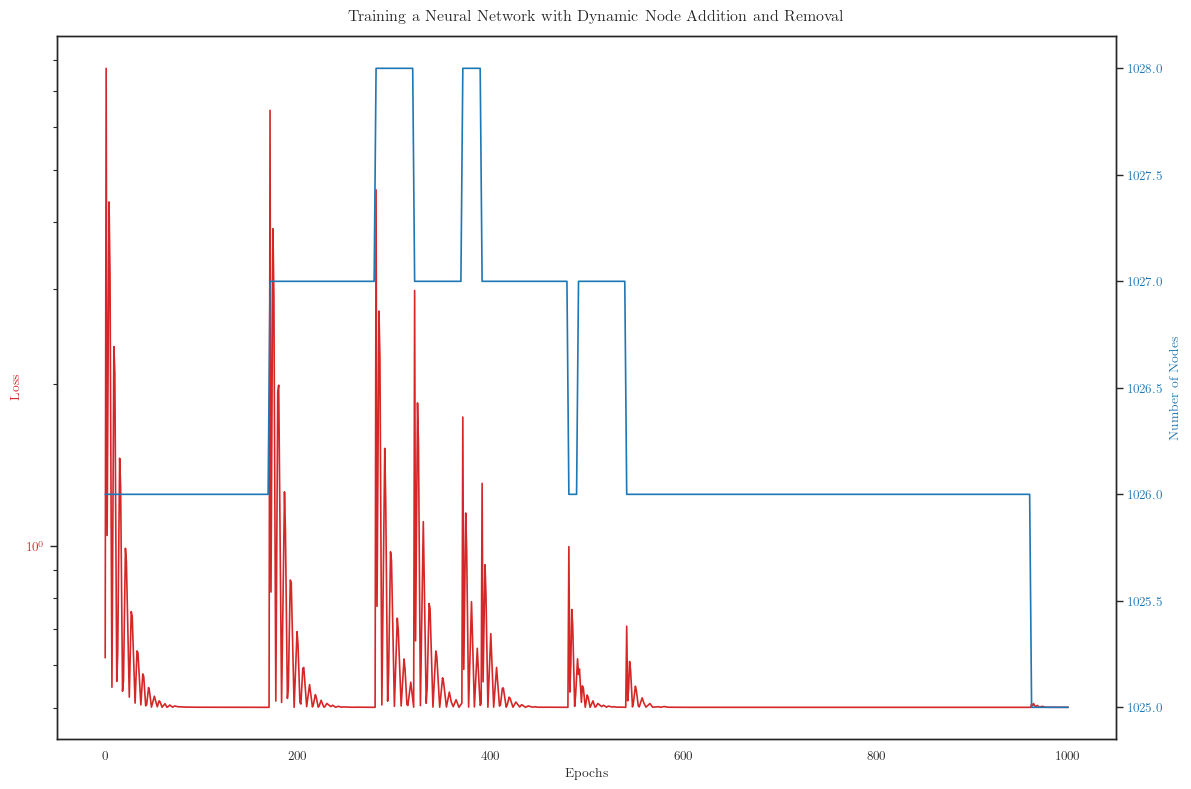

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 8))

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(np.arange(0,num_epochs), Loss_history, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of Nodes', color=color)  # we already handled the x-label with ax1
ax2.plot(np.arange(0,num_epochs), Node_history, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.suptitle("Training a Neural Network with Dynamic Node Addition and Removal")
fig.tight_layout()


In [ ]:
model

Model(
  layers=[
    Linear(
      weight=f64[1023,1],
      bias=f64[1023],
      in_features=1,
      out_features=1023,
      use_bias=True
    ),
    Linear(
      weight=f64[1,1023],
      bias=f64[1],
      in_features=1023,
      out_features=1,
      use_bias=True
    )
  ]
)

In [ ]:
x_test = jnp.linspace(0, 2 * jnp.pi, 50).reshape(-1, 1)
y_test = jnp.sin(jnp.linspace(0, 2 * jnp.pi, 50)).reshape(-1, 1)
y_pred = jax.vmap(model)(x_test)


In [ ]:
def plot_results(x, y_true, y_pred):
    plt.axes().set_aspect('equal')
    plt.plot(x, y_true, label='True sin(x)')
    plt.plot(x, y_pred, "." ,label='Predicted sin(x)')
    
    plt.legend()
    plt.show()

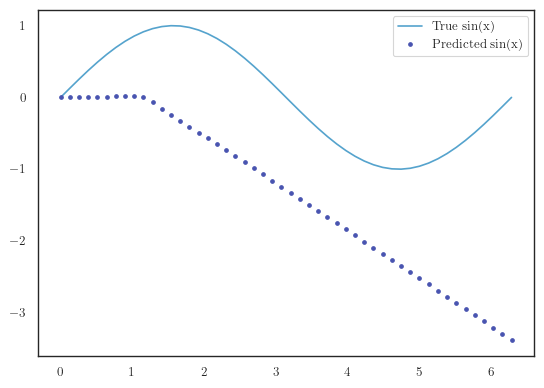

In [ ]:
plot_results(x_test, y_test, y_pred)

In [ ]:
for epoch in range(num_epochs, 2 * num_epochs):
    loss, model, opt_state = train_step(model, x, y, opt_state, opt.update)
    Node_history.append(count_nodes(model))
    Loss_history.append(loss)

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss}")

Epoch 1050, Loss: 0.5004906726820291
Epoch 1100, Loss: 0.5004899467953909
Epoch 1150, Loss: 0.5004895060058666
Epoch 1200, Loss: 0.5004891024012534
Epoch 1250, Loss: 0.5004886240811797
Epoch 1300, Loss: 0.5004882086181324
Epoch 1350, Loss: 0.5004885357709306
Epoch 1400, Loss: 0.5004873646144095
Epoch 1450, Loss: 0.5004866044677496
Epoch 1500, Loss: 0.5004861816073248
Epoch 1550, Loss: 0.5004855778596137
Epoch 1600, Loss: 0.5004849055891731
Epoch 1650, Loss: 0.5005288258060476
Epoch 1700, Loss: 0.5004838950443452
Epoch 1750, Loss: 0.5004831608930015
Epoch 1800, Loss: 0.5004844609085849
Epoch 1850, Loss: 0.5004833081365415
Epoch 1900, Loss: 0.5004812205637488
Epoch 1950, Loss: 0.5004819972208852
Epoch 2000, Loss: 0.5004811011345769


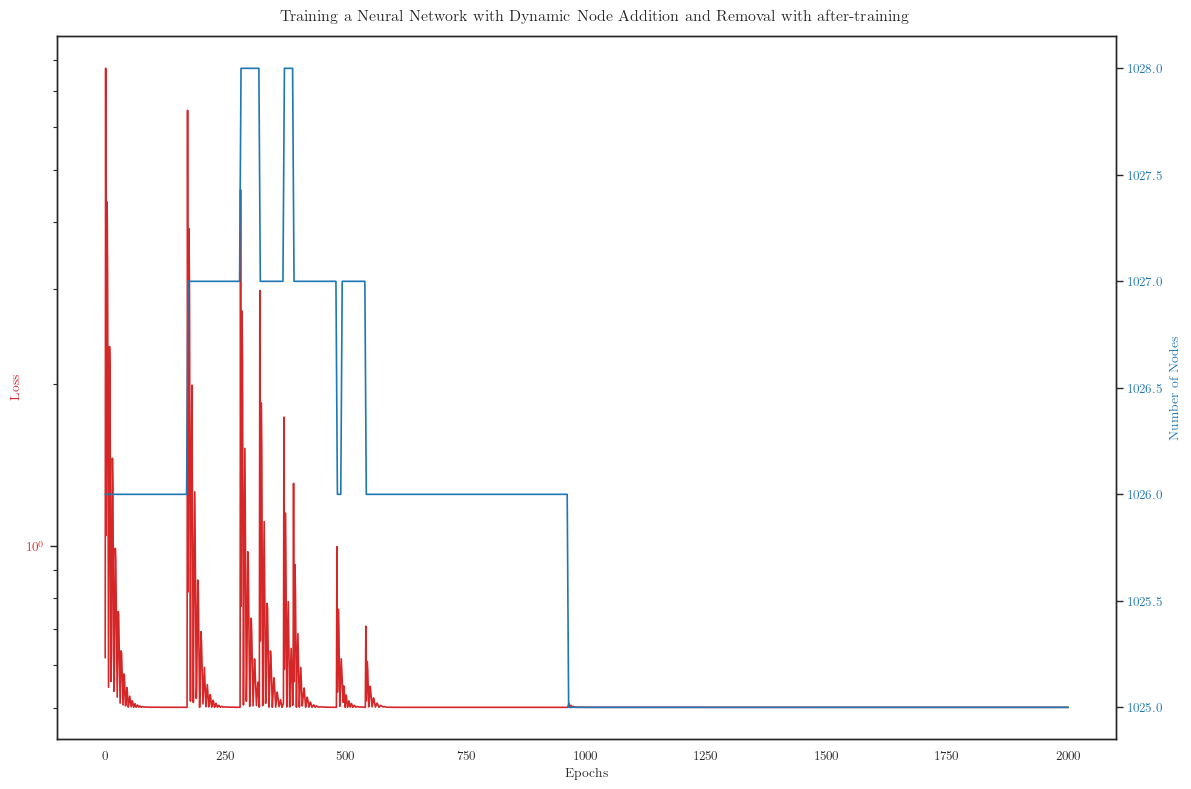

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 8))

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(np.arange(0,2*num_epochs), Loss_history, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of Nodes', color=color)  # we already handled the x-label with ax1
ax2.plot(np.arange(0,2*num_epochs), Node_history, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.suptitle("Training a Neural Network with Dynamic Node Addition and Removal with after-training")
fig.tight_layout()


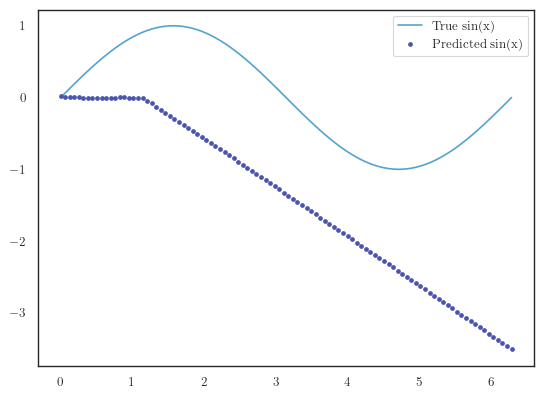

In [ ]:
x_test = jnp.linspace(0, 2 * jnp.pi, 100).reshape(-1, 1)
y_test = jnp.sin(jnp.linspace(0, 2 * jnp.pi, 100)).reshape(-1, 1)
y_pred = jax.vmap(model)(x_test)
plot_results(x_test, y_test, y_pred)

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()